## Init

In [1]:
import os

path = os.getcwd()
# set the working directory
os.chdir('c:\\Github\\new-peak-project\\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

G:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import *
from models.Specs.ModelSpec2 import ModelSpec2


import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner
import numpy as np
import pandas as pd

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Test 7: Model Specification 3

In [4]:
from models.Specs.ModelSpec3 import ModelSpec3
new_spec = ModelSpec3(num_intermediate_layers=2)

In [5]:
# get a logger to log the output
import logging
logging.basicConfig(level=logging.INFO)
from models.Specs.Drug import Drug

new_drug = Drug('D', 500, 500)
new_drug.add_regulation('R1', 'down')
new_spec.generate_specifications(1, 0, 42)
new_spec.add_drug(new_drug)

In [6]:
all_regs = new_spec.get_regulations()
for reg in all_regs:
    print(f"Reguation: {reg.from_specie} -> {reg.to_specie}, Type: {reg.reg_type}")

Reguation: R1 -> I1_1, Type: up
Reguation: I1_1 -> I2_1, Type: up
Reguation: I2_1 -> O, Type: up
Reguation: D -> R1, Type: down


In [7]:
builder = new_spec.generate_network('test', (200,1000),(0.5,1.5), (0.9,1.1))

INFO:models.Specs.ModelSpec3:Generated model test with 8 reactions.
INFO:models.Specs.ModelSpec3:Model States: 8
INFO:models.Specs.ModelSpec3:Model Parameters: 20
INFO:models.Specs.ModelSpec3:Model Reactions: 8


In [8]:
print(builder.get_antimony_model())

model test

J0: R1a -> R1; (J0_Vmax+D*J0_Kw0)*R1a/(J0_Km + R1a)
J1: R1 -> R1a; J1_Vmax*R1/(J1_Km + R1)
J2: I1_1a -> I1_1; J2_Vmax*I1_1a/(J2_Km + I1_1a)
J3: I1_1 -> I1_1a; (J3_Vmax+R1a*J3_Kw0)*I1_1/(J3_Km + I1_1)
J4: I2_1a -> I2_1; J4_Vmax*I2_1a/(J4_Km + I2_1a)
J5: I2_1 -> I2_1a; (J5_Vmax+I1_1a*J5_Kw0)*I2_1/(J5_Km + I2_1)
J6: Oa -> O; J6_Vmax*Oa/(J6_Km + Oa)
J7: O -> Oa; (J7_Vmax+I2_1a*J7_Kw0)*O/(J7_Km + O)

# State variables in the system
R1a=0
R1=648
I1_1a=0
I1_1=278
I2_1a=0
I2_1=595
Oa=0
O=546

# Parameters in the system
J0_Km=52.35274480381393
J0_Vmax=0.9042263807894625
J0_Kw0=0.09973403066676913
J1_Km=120.71314425800165
J1_Vmax=6.341046298296328
J2_Km=55.24233255252354
J2_Vmax=6.1146719644087115
J3_Km=99.87742871105763
J3_Vmax=1.1756408490335717
J3_Kw0=0.11026024748307785
J4_Km=146.9082683356113
J4_Vmax=6.8270533263517725
J5_Km=133.71645775061668
J5_Vmax=0.7791296706019223
J5_Kw0=0.0710465755850813
J6_Km=55.92462968797099
J6_Vmax=5.481514034655199
J7_Km=70.84794669853227
J7_Vmax=0.

In [9]:
from models.Solver.RoadrunnerSolver import RoadrunnerSolver

solver = RoadrunnerSolver()
solver.compile(builder.get_sbml_model())
res = solver.simulate(0, 1000, 100)


In [10]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    100 non-null    float64
 1   R1a     100 non-null    float64
 2   R1      100 non-null    float64
 3   I1_1a   100 non-null    float64
 4   I1_1    100 non-null    float64
 5   I2_1a   100 non-null    float64
 6   I2_1    100 non-null    float64
 7   Oa      100 non-null    float64
 8   O       100 non-null    float64
dtypes: float64(9)
memory usage: 7.2 KB


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import hashlib
import numpy as np

def visualize_time_series(df, columns=None, activated_only=False, outcome_activation=False, show_legend=True):
    """
    Visualize time series data from a pandas DataFrame with deterministic coloring.
    
    Parameters:
    df (pd.DataFrame): Input dataframe containing 'time' column
    columns (list): Selected columns to plot (None plots all non-time columns)
    activated_only (bool): Show only columns ending with 'a' (activated species)
    outcome_activation (bool): Special mode to plot only 'O' and 'Oa'
    show_legend (bool): Toggle legend display
    """
    # Set visual properties
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'Arial'
    rcParams['font.size'] = 12
    rcParams['axes.titlesize'] = 16
    rcParams['axes.labelsize'] = 14
    
    # Handle special cases
    if outcome_activation:
        columns = ['O', 'Oa']
    elif activated_only:
        columns = [col for col in df.columns if col.endswith('a') and col != 'time']
    elif columns is None:
        columns = [col for col in df.columns if col != 'time']
    
    # Prepare custom colors
    np.random.seed(42)  # Fixed random seed for reproducibility
    
    # Create custom color handling
    palette = sns.color_palette('colorblind') + sns.color_palette('bright')
    
    # Remove blues from base palette
    palette = [color for color in palette 
               if not (color[0] < 0.3 and color[1] < 0.6 and color[2] > 0.7)]
    
    # Generate deterministic color mapping
    unique_species = sorted(set(columns))  # Sort for deterministic ordering
    color_map = {}
    
    # Assign fixed colors for O and Oa
    color_map['O'] = (0.6, 0.8, 1.0)   # Light blue
    color_map['Oa'] = (0.0, 0.3, 0.7)  # Dark blue
    
    # Assign colors to other species
    for i, specie in enumerate(unique_species):
        if specie not in ['O', 'Oa']:
            # Use modulo to cycle through available colors
            color_map[specie] = palette[i % len(palette)]
    
    # Prepare data for plotting
    melt_df = df.melt(id_vars='time', value_vars=columns, 
                      var_name='Species', value_name='Value')
    
    # Create plot
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(
        data=melt_df, 
        x='time', 
        y='Value', 
        hue='Species',
        palette=color_map,
        linewidth=2.5
    )
    
    # Customize plot
    title_suffix = ''
    if outcome_activation:
        title_suffix = ' (Outcome Activation)'
    elif activated_only:
        title_suffix = ' (Activated Only)'
    
    ax.set_title(f'Time Series of Selected Species{title_suffix}')
    ax.set_xlabel('Time', weight='bold')
    ax.set_ylabel('Concentration/Value', weight='bold')
    
    # Configure legend
    if show_legend:
        plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

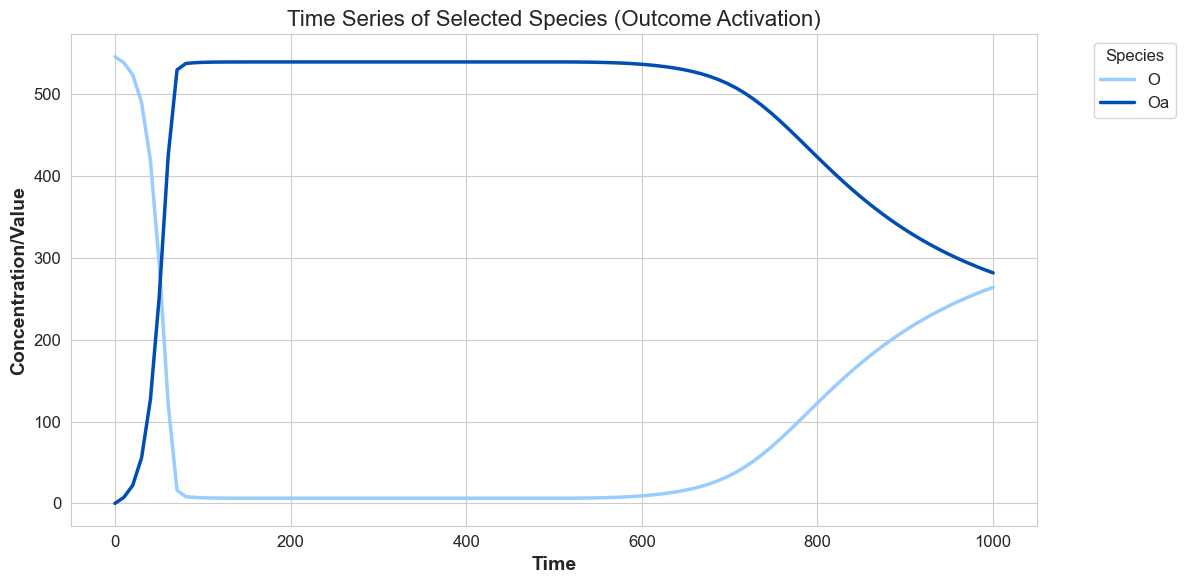

In [12]:

visualize_time_series(res, outcome_activation=True)

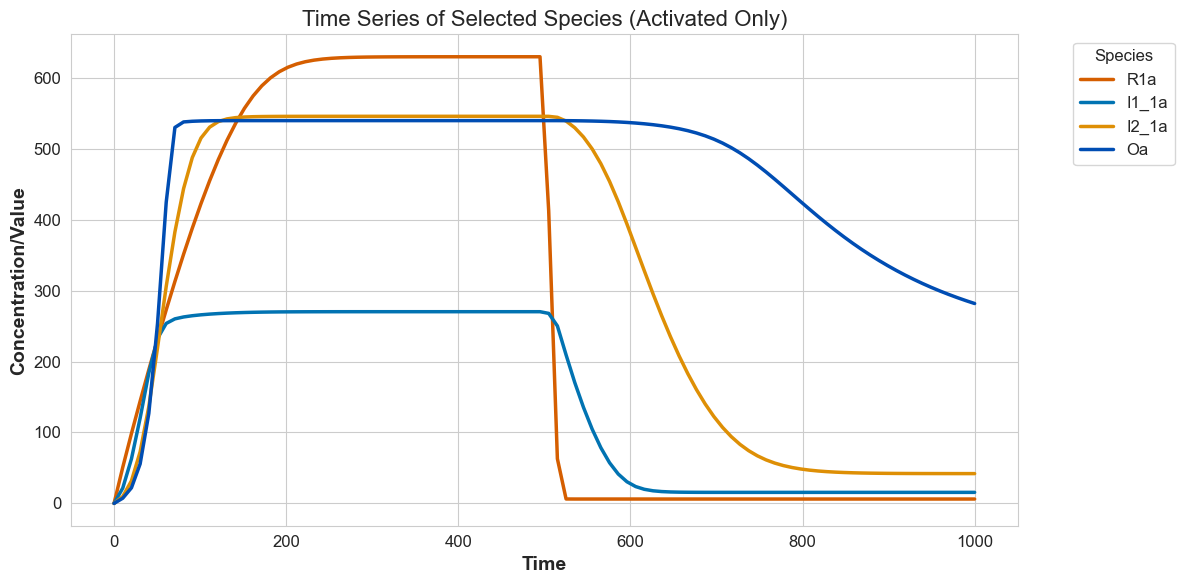

In [13]:
visualize_time_series(res, activated_only=True)

In [14]:
def create_layers(num_intermediate_layers, num_cascades, drugs):
    '''
    Create layers based on the number of cascades and regulations.
    '''
    layers = {}
    layers['Drugs'] = drugs
    layers['Receptors'] = [f'R{i+1}' for i in range(num_cascades)]
    for i in range(num_intermediate_layers):
        layers[f'Layer{i+1}'] = [f'I{i+1}_{j+1}' for j in range(num_cascades)]
    layers['Outcome'] = ['O']
    return layers

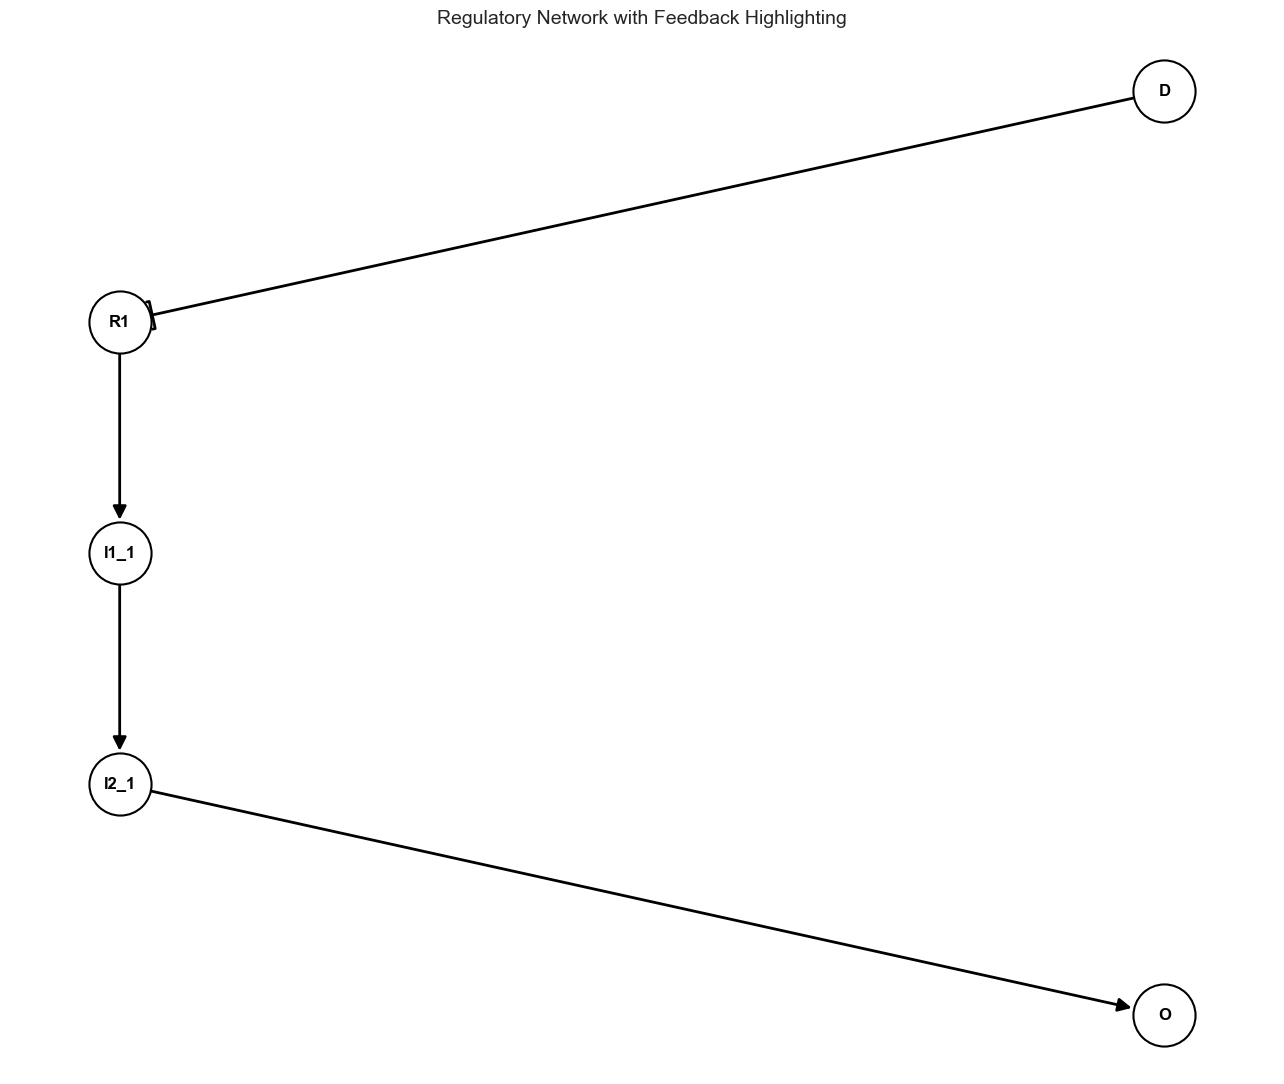

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from dataclasses import dataclass
logging.basicConfig(level=logging.NOTSET)

def calculate_positions(layers):
    """Dynamically calculate node positions based on layers structure"""
    pos = {}
    vertical_spacing = 1.0 / len(layers)
    layer_y_positions = [1.0 - i*vertical_spacing for i in range(len(layers))]
    max_horizontal_nodes = max(len(nodes) for nodes in layers.values())
    
    for i, (layer_name, nodes) in enumerate(layers.items()):
        y = layer_y_positions[i]
        horizontal_spacing = 1.5 / max(len(nodes), 1)
        
        # Center-align nodes per layer
        x_start = -(len(nodes)-1)*horizontal_spacing/2
        for j, node in enumerate(nodes):
            pos[node] = (x_start + j*horizontal_spacing, y)
            
    return pos

def visualize_network(layers, regulations, feedback_regulations=None):
    """Visualize network with custom edge coloring feedback"""
    # Create graph and positions following your layer logic [1][4]
    G = nx.DiGraph()
    all_regulations = regulations + (feedback_regulations if feedback_regulations else [])
    
    # Populate graph with all regulations
    for regulation in all_regulations:
        G.add_node(regulation.from_specie)
        G.add_node(regulation.to_specie)
        G.add_edge(regulation.from_specie, regulation.to_specie, 
                   regulation_type=regulation.reg_type)
    
    # Create quick lookup structure for feedback regulations
    feedback_edges = set()
    if feedback_regulations:
        feedback_edges = {(r.from_specie, r.to_specie) for r in feedback_regulations}
    
    # Position calculation per your dynamic system
    pos = calculate_positions(layers)
    
    # Dynamic figure sizing based on layers [1]
    fig_width, fig_height = 8 + 1 * len(layers), 6 + 1 * len(layers)
    plt.figure(figsize=(fig_width, fig_height))
    
    # Node drawing (unchanged)
    nx.draw_networkx_nodes(G, pos, node_color='white', 
                           edgecolors='black', node_size=2000, linewidths=1.5)
    
    # EDGE DRAWING WITH NEW COLOR LOGIC
    for edge in G.edges(data=True):
        src, dst, data = edge
        is_feedback = (src, dst) in feedback_edges
        
        # Determine styling parameters
        if is_feedback:
            edge_color = 'blue' if data['regulation_type'] == 'up' else 'red'
        else:  # Non-feedback edge
            edge_color = 'black'
        
        arrowstyle = '-|>' if data['regulation_type'] == 'up' else '-['
        
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(src, dst)],
            edge_color=edge_color,
            width=2,
            arrowstyle=arrowstyle,
            arrowsize=20 if data['regulation_type'] == 'up' else 10,
            min_target_margin=24,
        )
    
    # Labels and finishing
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    plt.title("Regulatory Network with Feedback Highlighting", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Usage example with your parameters
layers = create_layers(num_intermediate_layers=2, num_cascades=3, drugs=['D'])
regulations = new_spec.get_regulations()  
feedback_regulations = new_spec.get_feedback_regulations()  
visualize_network(layers, regulations, feedback_regulations=feedback_regulations)

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_positions(layers):
    """Dynamically calculate positions with even spacing"""
    pos = {}
    vertical_spacing = 1.0 / len(layers)
    layer_y_positions = [1.0 - i*vertical_spacing for i in range(len(layers))]
    
    for i, (layer_name, nodes) in enumerate(layers.items()):
        y = layer_y_positions[i]
        num_nodes = len(nodes)
        horizontal_spacing = 1.5 / max(num_nodes, 1)
        
        # Center-align nodes in layer
        x_start = - (num_nodes - 1) * horizontal_spacing / 2
        for j, node in enumerate(nodes):
            pos[node] = (x_start + j*horizontal_spacing, y)
            
    return pos

def visualize_network_2(layers, regulations, feedback_regulations=None):
    """Final visualization with smart edge handling"""
    # Create graph and positions
    G = nx.DiGraph()
    all_regulations = regulations + (feedback_regulations or [])
    
    # Populate graph
    for reg in all_regulations:
        G.add_node(reg.from_specie)
        G.add_node(reg.to_specie)
        G.add_edge(reg.from_specie, reg.to_specie, 
                  regulation_type=reg.reg_type)

    # Identify special edges
    bidirectional = set()
    cross_layer = set()
    same_layer = set()

    # Get layer mappings
    node_to_layer = {}
    for layer_name, nodes in layers.items():
        for node in nodes:
            node_to_layer[node] = layer_name

    for u, v in G.edges():
        # Bidirectional check
        if G.has_edge(v, u):
            bidirectional.add((u, v))
            
        # Layer relationship check
        u_layer = list(layers.keys()).index(node_to_layer[u])
        v_layer = list(layers.keys()).index(node_to_layer[v])
        
        if u_layer == v_layer:
            same_layer.add((u, v))
        elif abs(u_layer - v_layer) > 1:
            cross_layer.add((u, v))

    # Position calculation
    pos = calculate_positions(layers)
    feedback_edges = {(r.from_specie, r.to_specie) for r in (feedback_regulations or [])}

    # Dynamic figure sizing
    num_layers = len(layers)
    max_nodes = max(len(nodes) for nodes in layers.values())
    plt.figure(figsize=(8 + max_nodes*1.2, 4 + num_layers*1.5))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='white', 
                          edgecolors='black', node_size=2500, linewidths=1.5)

    # Draw edges with smart curvature
    for edge in G.edges(data=True):
        u, v, data = edge
        is_feedback = (u, v) in feedback_edges
        is_bidi = (u, v) in bidirectional
        is_cross = (u, v) in cross_layer
        is_same_layer = (u, v) in same_layer
        
        # Determine styling parameters
        if is_feedback:
            edge_color = 'blue' if data['regulation_type'] == 'up' else 'red'
        else:
            edge_color = 'black'
            
        arrowstyle = '-|>' if data['regulation_type'] == 'up' else '-['
        
        # Calculate curvature parameters
        if is_bidi:
            rad = 0.25  # Alternate direction for bidirectional
        elif is_cross:
            rad = 0.3
        elif is_same_layer:
            rad = 0.4
        else:
            rad = 0.0
        
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            edge_color=edge_color,
            width=2.5 if is_feedback else 1.8,
            style='solid',
            arrowstyle=arrowstyle,
            arrowsize=25 if data['regulation_type'] == 'up' else 10,
            node_size=2500,
            min_target_margin=15,
            connectionstyle=f"arc3,rad={str(rad)}"
        )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, 
                           font_weight='bold', 
                           verticalalignment='center')

    plt.title("Regulatory Network Visualization", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

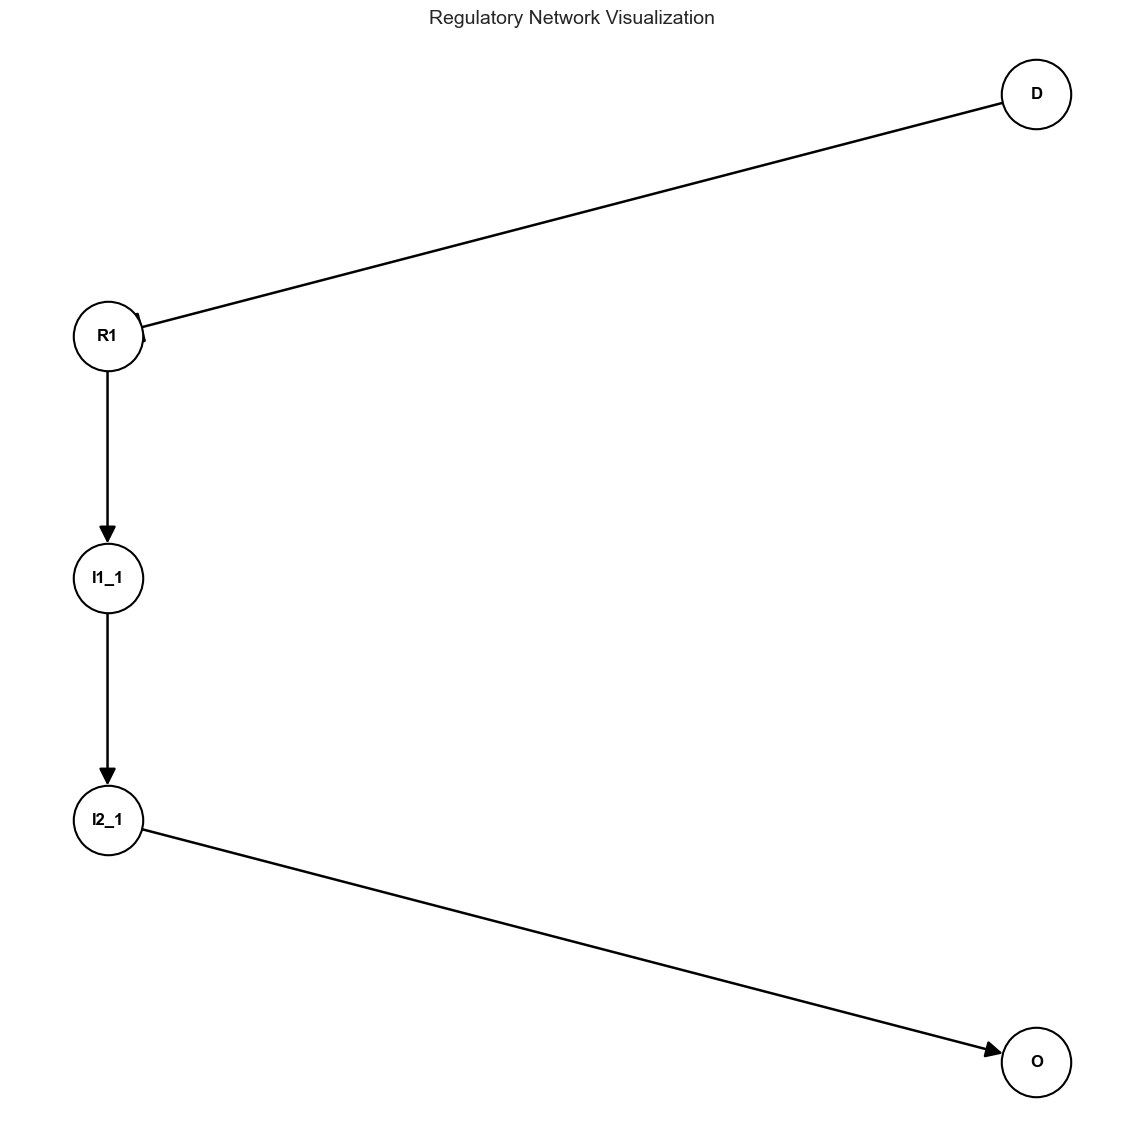

In [17]:
layers = create_layers(num_intermediate_layers=2, num_cascades=3, drugs=['D'])
regulations = new_spec.get_regulations()  
feedback_regulations = new_spec.get_feedback_regulations()  
visualize_network_2(layers, regulations, feedback_regulations=feedback_regulations)

### Sensitivity Analysis

In [18]:
import numpy as np
import pandas as pd

# Configuration parameters
PERTURBATION = 0.5  # 1% perturbation of initial values
SIM_START = 0
SIM_END = 200
POINTS = 100

def sensitivity_analysis(solver, baseline_conditions):
    """
    Perform sensitivity analysis using set_state_values before each simulation
    Returns DataFrame with sensitivity indices [2]
    """
    # Run baseline simulation
    solver.set_state_values(baseline_conditions)  # Initialize with baseline [2]
    baseline_result = solver.simulate(SIM_START, SIM_END, POINTS)
    oa_baseline = baseline_result['Oa'].iloc[-1]  # Final Oa concentration [1]
    
    # Identify state variables (excluding time and outcome nodes)
    state_vars = [col for col in baseline_result.columns if col not in {'time', 'Oa', 'O'}]
    
    sensitivity_data = []
    
    for state_var in state_vars:
        try:
            # Create modified conditions (1% increase)
            mod_conditions = baseline_conditions.copy()
            original_value = baseline_conditions[state_var]
            mod_conditions[state_var] = original_value * (1 + PERTURBATION)
            
            # Apply state changes and simulate [2]
            if not solver.set_state_values(mod_conditions):
                raise RuntimeError(f"Failed to set {state_var}")
                
            mod_result = solver.simulate(SIM_START, SIM_END, POINTS)
            oa_mod = mod_result['Oa'].iloc[-1]
            
            # Calculate sensitivity (Δoutput/Δinput)
            delta_oa = oa_mod - oa_baseline
            delta_input = original_value * PERTURBATION
            sensitivity_index = delta_oa / delta_input
            
            sensitivity_data.append({
                'Species': state_var,
                'Sensitivity_Index': sensitivity_index,
                'Baseline_Oa': oa_baseline,
                'Perturbed_Oa': oa_mod
            })
            
            # Reset to baseline for next iteration [2]
            solver.set_state_values(baseline_conditions)
            
        except Exception as e:
            print(f"Error processing {state_var}: {str(e)}")
            continue

    return pd.DataFrame(sensitivity_data)





In [19]:
baseline_conditions = {col: res[col].iloc[0] for col in res.columns if col != 'time'}
sensitivity_df = sensitivity_analysis(solver, baseline_conditions)

C:\Users\l8105\AppData\Local\Temp\ipykernel_25232\2384981852.py:42: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity_index = delta_oa / delta_input
C:\Users\l8105\AppData\Local\Temp\ipykernel_25232\2384981852.py:42: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity_index = delta_oa / delta_input
C:\Users\l8105\AppData\Local\Temp\ipykernel_25232\2384981852.py:42: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity_index = delta_oa / delta_input


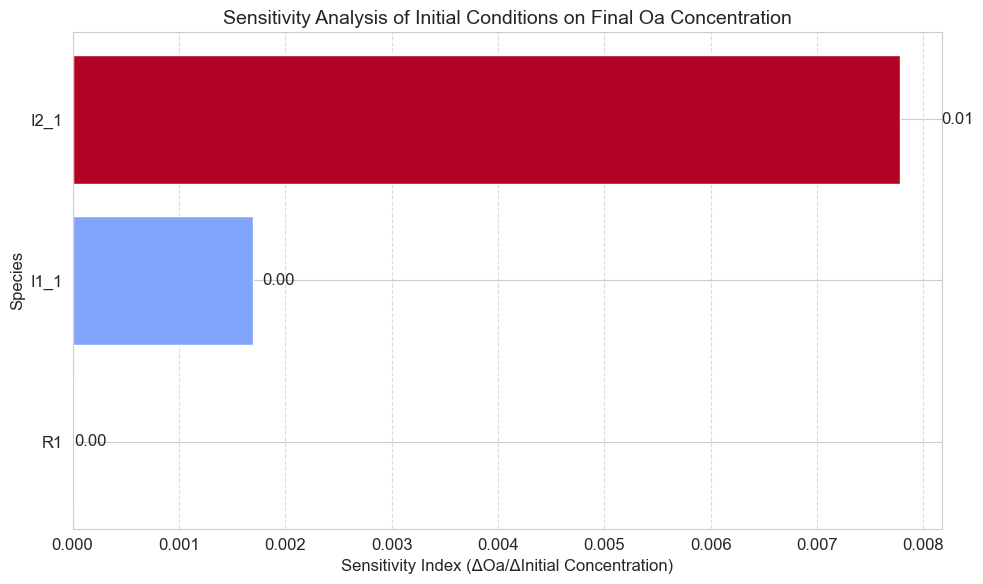

In [20]:
import matplotlib.pyplot as plt

# Assuming you have results_df from the sensitivity analysis
def plot_sensitivity(results_df):
    # Sort by absolute sensitivity for better visualization
    df_sorted = results_df.sort_values('Sensitivity_Index', key=abs)
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(df_sorted['Species'], df_sorted['Sensitivity_Index'],
                    color=plt.cm.coolwarm(df_sorted['Sensitivity_Index']/df_sorted['Sensitivity_Index'].abs().max()))
    
    plt.xlabel('Sensitivity Index (ΔOa/ΔInitial Concentration)', fontsize=12)
    plt.ylabel('Species', fontsize=12)
    plt.title('Sensitivity Analysis of Initial Conditions on Final Oa Concentration', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add values on bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width*1.05 if width >=0 else width*1.2, 
                 bar.get_y() + bar.get_height()/2,
                 f'{width:.2f}', 
                 va='center')
    
    plt.tight_layout()
    plt.savefig('sensitivity_analysis.png', dpi=300)
    plt.show()

plot_sensitivity(sensitivity_df)